Interpolación

Por Pablo Angulo y Fabricio Macià para ETSIN@UPM

In [2]:
import numpy as np
import numpy.random
import scipy as sp
import scipy.linalg as la
from scipy.interpolate import lagrange
import sympy as sym
import matplotlib.pyplot as plt

# Interpolación

En ocasiones solo tenemos acceso a valores aproximados de una función para un rango finito de entradas. Los valores pueden haber sido obtenidos mediante un experimento, o mediante alguna técnica de aproximación. Nuestro objetivo en este capítulo es describir técnicas que permiten construir una función cuyos valores en un conjunto específico de puntos coinciden con los valores que hemos observado o construido mediante algún otro proceso. 

La **definición** formal de **interpolante** es la siguiente:

Dado un conjunto finito de datos $y_0,y_1,...,y_N$ tomados en puntos $x_0,x_1,...,x_N$, un *interpolante* o *función que interpola* esos datos por esos puntos en una función continua $F(x)$  (o al menos continua a trozos) que ajusta exactamente esos datos:

$$
f(x_0)=y_0, \:f(x_1)=y_1,\dots,f(x_N)=y_N.
$$

Vamos a centrarnos especialmente en funciones de una variable. No obstante, hay aplicaciones muy importantes que requieren interpolar funciones de varias variables (el método de elementos finitos, por ejemplo). Como vimos en el tema de aproximación de raíces, pasar de una a varias variables conlleva ciertas dificultades técnicas; tened esto presente. 

## Aplicaciones

Son múltiples. Entre otras:

 - Completar datos parciales (Data filling)
 - Aproximar funciones complicadas por otras de manejo computacional más sencillo
 - Es una pieza fundamental de otros algoritmos que vamos a estudiar
   - Aproximación de raíces (cuando vimos el método de la secante)
   - Optimización, maximización o minimización de funciones
   - Interación y diferenciación numérica
   - El método de elementos finitos


# El polinomio interpolador

Conviene que el interpolante sea una función lo más sencilla posible, en el sentido que sea computacionalmente eficiente evaluarla. En este sentido, una familia de funciones especialmente adecuada es la formada por los **polinomios**.

Buscamos un interpolante en la forma de un polinomio
$$
P(x) = a_0 + a_1\cdot x + \dots + a_N\cdot x^N
$$
que pase por los $N+1$ puntos (o nodos) de interpolación
$$
P(x_0)=y_0,\:P(x_1)=y_1,\dots,P(x_N)=y_N.
$$
Si los puntos $x_0,\dots,x_N$ son todos distintos, hay un único polinomio $P(x)$ de grado menos o igual a $N$ que cumpla esas $N+1$ condiciones. Este polinomio se denomina *polinomio interpolador*.

## El método de fuerza bruta

Vamos a demostrar la existencia y unicidad del polinomio interpolador describiendo un método para construirlo.

Comenzamos desarrollando acada una de las condiciones que tiene que cumplir el polinomio:

$$
a_0+a_1\,x_0+\dots+a_N\,x_0^N=y_0,
$$
$$
a_0+a_1\,x_1+\dots+a_N\,x_1^N=y_1,
$$
$$
\vdots
$$
$$
a_0+a_1\,x_N+\dots+a_N\,x_N^N=y_N.
$$

A la vista de esto, concluimos que  los coeficientes del polinomio interpolador son la solución del sistema de ecuaciones

$$
{\displaystyle {\begin{bmatrix}1&x _{0}&\dots &x _{0}^{N}\\1&x _{1}&\dots &x _{1}^{N}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&x _{N}&\dots &x _{N}^{N}\end{bmatrix}}\,
{\begin{bmatrix}a _{0}\\a_1\\\vdots\\a_N\end{bmatrix}}={\begin{bmatrix}y_{0}\\y_1\\\vdots\\y_N\end{bmatrix}}.}
$$

Este sistema tiene una única solución puesto que la matriz de coeficientes del sistema es no singular. Su determinante es igual a:
$$
\prod_{i>j=0}^N(x_i-x_j)=(x_1-x_0)(x_2-x_0)\dots (x_N-x_{N-1}),
$$
es distinto de cero (puesto que todos los puntos son distintos).

La matriz anterior se conoce como matriz de *Vandermonde*. Comprueba, haciendo el cálculo o investigando en un libro o en internet que la expresión anterior es igual a a su determinante.

### Ejercicio

Construye la matriz anterior para una lista de puntos `xs`, y resuelve el sistema usando
```python
import scipy.linalg as la
# Resuelve A*x = b
la.solve(A, b) 
```


In [2]:
# En el cuaderno numpy_s puedes encontrar otras formas vectorizadas
# de construir esta matriz
def vandermonde(xs):
    '''matriz de Vandermonde'''
    l = len(xs)
    M = np.zeros((l,l))
    for i in range(l):
        for j in range(l):
            M[i,j] = xs[i]**j
    return M

In [3]:
xs = np.arange(3,8)
ys = np.sin(xs) + xs
A = vandermonde(xs)
import scipy.linalg as la
# Resuelve A*x = b
la.solve(A, ys) 

array([-7.00711246, 10.67302269, -4.04282101,  0.63889694, -0.03377363])

> - Comparamos la solución obtenida con el resultado usando `polyfit`

In [4]:
# mismos coeficientes, pero almacenados en el orden inverso
np.polyfit(xs,ys, len(xs)-1)

array([-0.03377363,  0.63889694, -4.04282101, 10.67302269, -7.00711246])

In [5]:
cs = la.solve(A, ys)
# np.flip(mi_array) permite invertir el orden de los elementos de un array
# reverse() es para listas
np.flip(cs)

array([-0.03377363,  0.63889694, -4.04282101, 10.67302269, -7.00711246])

### Pros y contras

Este es un método para calcular el polinomio interpolador. No obstante, tiene serios

inconvenientes:
- Es muy costoso. Involucra resolver un sistema $(N+1)\times(N+1)$.
- Si añadimos puntos y datos a los que ya teníamos, hemos de volver a calcular el polinomio desde cero.

y alguna ventaja:
- El polinomio interpolador se obtiene como sumas de potencias de $x$:
$$
a_0 + a_1\cdot x + \dots + a_N\cdot x^N
$$
y se puede evaluar muy eficientemente mediante el algoritmo de Horner.

## La forma de Lagrange

Para obtener un método que permita calcular el polinomio interpolación más eficientemente, hemos de renunciar a expresarlo como suma de potencias de $x$.

Vamos a representarlo mediante sumas de  polinomios de Lagrange:

$$
\ell _{j}(x):=\prod _{\begin{smallmatrix}0\leq m\leq N\\m\neq j\end{smallmatrix}}{\frac {x-x_{m}}{x_{j}-x_{m}}};
$$

usando una notación menos compacta, la identidad anterior se escribe:

$$
\ell _{j}(x) = \frac {(x-x_{0})}{(x_{j}-x_{0})}\dots \frac {(x-x_{j-1})}{(x_{j}-x_{j-1})}{\frac {(x-x_{j+1})}{(x_{j}-x_{j+1})}}\dots \frac {(x-x_{N})}{(x_{j}-x_{N})}.
$$

Observad que cada $\ell _{j}(x)$ es un polimonio de grado $N$ que tiene la siguiente propiedad crucial:

$$
\ell _{j}(x_j)=1,\quad \ell _{j}(x_m)=0,\text{ si }m\neq j.
$$

Si ahora buscamos el polinomio interpolador $P(x)$ en la forma:

$$
P(x):=b_0\ell _{0}(x)+b_1\ell _{1}(x)+\dots+b_N\ell _{N}(x),
$$

al imponer las condiciones $P(x_j)=y_j$ para $j=0,\dots, N$ obtenemos:

$$
b_0=y_0,\, b_1=y_1,\dots, b_N=y_N.
$$

En otras palabras, el polinomio interpolador es:

$$
P(x):=y_0\ell _{0}(x)+y_1\ell _{1}(x)+\dots+y_N\ell _{N}(x).
$$

Los polinomios de Lagrange $\ell _{0},\dots, \ell _{N}$ forman una *base* del espacio de todos los polinomios de grado menor o igual a $N$. Se conoce como *base de Lagrange*.

In [26]:
def lagrange(xs, ys, x_eval):
    '''Polinomio k-esimo de la base de Lagrange
    
    INPUTS:
        - `xs` coordenada x de los puntos de interpolación
        - `ys` coordenada y de los puntos de interpolación
        - `x_eval` es una coordenada, o un array de coordenadas x
          donde evaluar el polinomio
    
    OUTPUTS
        - `y_eval` array resultado de evaluar el polinomio interpolador
        en x_eval
    '''
    n = len(xs)
    y_eval = np.zeros_like(x_eval)
    for i in range(n):
        xi = xs[i]
        yi = ys[i]
        base = np.ones_like(x_eval)
        for j in range(n):
            if j!=i:
                xj = xs[j]
                base = base*(x_eval - xj)/(xi - xj)
        y_eval = y_eval + base*yi
    return y_eval

In [7]:
xs = range(11)
n  = len(xs)
# ys es todo ceros, salvo el índice 3
ys = np.zeros(n)
ys[1] = 1
for k in xs:
    print('x=', k, ', P(x)=', lagrange(xs, ys, k))

x= 0 , P(x)= 0.0
x= 1 , P(x)= 1.0
x= 2 , P(x)= 0.0
x= 3 , P(x)= 0.0
x= 4 , P(x)= 0.0
x= 5 , P(x)= 0.0
x= 6 , P(x)= 0.0
x= 7 , P(x)= 0.0
x= 8 , P(x)= 0.0
x= 9 , P(x)= 0.0
x= 10 , P(x)= 0.0


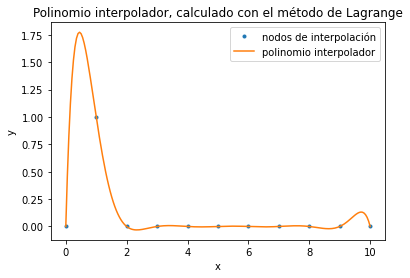

In [8]:
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,10,200)
y_eval = lagrange(xs, ys, x_eval)
plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador')
plt.title('Polinomio interpolador, calculado con el método de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Ejercicio

- Dibuja todos los polinomios de la base de Lagrange para 10 puntos equiespaciados
- Interpola la función $f(x)=\sin(x)$ en el intervalo $[0,2\pi]$ usando $N=6$ puntos de interpolación. Calcula el máximo error cometido.
- Interpola la función $f(x)=x^5 + x$ en el intervalo $[-1, 1]$ usando $N=4$ puntos de interpolación. Calcula el máximo error cometido.
- Interpola la función $f(x)=x^5 + x$ en el intervalo $[-1, 1]$ usando $N=6$ puntos de interpolación. Calcula el máximo error cometido. Interpreta el resultado.

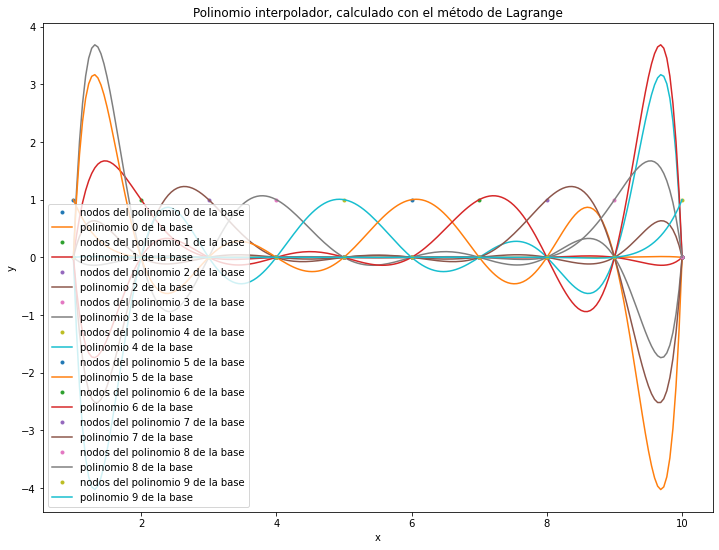

In [9]:
xs = np.arange(1,11)
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(1,10,200)
plt.figure(figsize=(12,9))
for n in range(10):
    ys = np.zeros(10)
    ys[n] = 1
    y_eval = lagrange(xs, ys, x_eval)
    plt.plot(xs, ys, '.', label='nodos del polinomio %d de la base'%n)
    plt.plot(x_eval, y_eval, label='polinomio %d de la base'%n)
plt.title('Polinomio interpolador, calculado con el método de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

- Interpola la función $f(x)=\sin(x)$ en el intervalo $[0,2\pi]$ usando $N=6$ puntos de interpolación. Calcula el máximo error cometido.

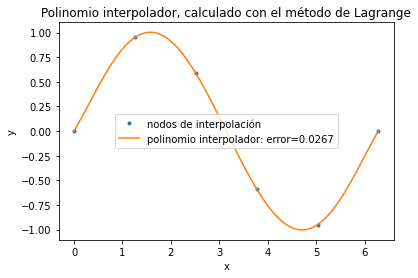

In [10]:
xs = np.linspace(0,2*np.pi,6)
ys = np.sin(xs)
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,2*np.pi,200)
y_eval = lagrange(xs, ys, x_eval)

# ys_true es la función que queremos interpolar evaluada en x_eval
ys_true = np.sin(x_eval)

# np.abs(ys-y_eval).max() es el error máximo, de entre los 200 puntos de x_eval
# que es representativo del error cometido.
error = np.abs(ys_true-y_eval).max()

plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador: error=%.4f'%error)
plt.title('Polinomio interpolador, calculado con el método de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

- Interpola la función $f(x)=x^5 + x$ en el intervalo $[-1, 1]$ usando $N=4$ puntos de interpolación. Calcula el máximo error cometido.

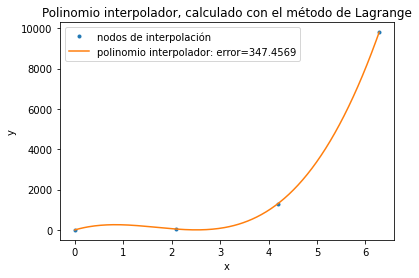

In [11]:
xs = np.linspace(0,2*np.pi,4)
def f(x):
    return x**5 + x
ys = f(xs)
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,2*np.pi,200)
y_eval = lagrange(xs, ys, x_eval)

# ys_true es la función que queremos interpolar evaluada en x_eval
ys_true = f(x_eval)

# np.abs(ys-y_eval).max() es el error máximo, de entre los 200 puntos de x_eval
# que es representativo del error cometido.
error = np.abs(ys_true-y_eval).max()

plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador: error=%.4f'%error)
plt.title('Polinomio interpolador, calculado con el método de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

- Interpola la función $f(x)=x^5 + x$ en el intervalo $[-1, 1]$ usando $N=6$ puntos de interpolación. Calcula el máximo error cometido. Interpreta el resultado.

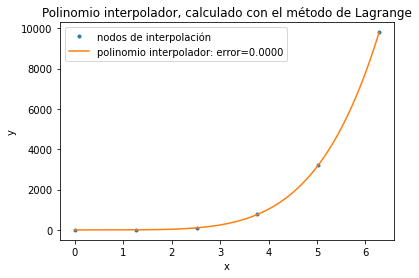

In [12]:
xs = np.linspace(0,2*np.pi,6)
def f(x):
    return x**5 + x
ys = f(xs)
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,2*np.pi,200)
y_eval = lagrange(xs, ys, x_eval)

# ys_true es la función que queremos interpolar evaluada en x_eval
ys_true = f(x_eval)

# np.abs(ys-y_eval).max() es el error máximo, de entre los 200 puntos de x_eval
# que es representativo del error cometido.
error = np.abs(ys_true-y_eval).max()

plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador: error=%.4f'%error)
plt.title('Polinomio interpolador, calculado con el método de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

> El error es cero porque tenemos una lista de n=6 puntos, y el polinomio interpolador es el único polinomio de grado <= n-1 que pasa por esos puntos. Pero la función que estamos interpolando es un polinomio de grado <=n-1=5, luego el polinomio interpolador es exactamente igual a la función.

### Ejercicio

Compara el resultado mediante la base de Lagrange con el primer método que hemos descrito para algún ejemplo concreto.

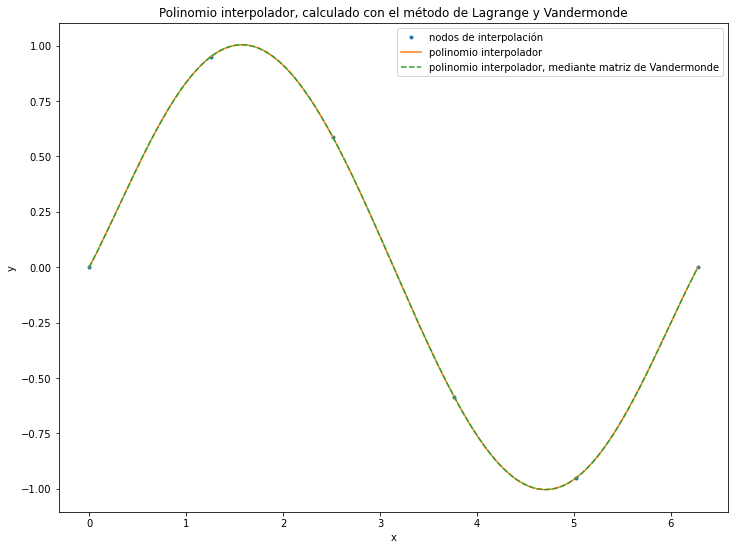

In [13]:
xs = np.linspace(0,2*np.pi,6)
ys = np.sin(xs)
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,2*np.pi,200)
y_eval = lagrange(xs, ys, x_eval)


A = vandermonde(xs)
# Resuelve A*x = b
cs = la.solve(A, ys)

# np.polyval sirve para evaluar un polinomio, pero los coeficientes
# vienen de mayor a menor, como cuando llamamos a polyval
cs_flip = np.flip(cs)
y_vandermonde = np.polyval(cs_flip, x_eval)

plt.figure(figsize=(12,9))
plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador')
plt.plot(x_eval, y_vandermonde, '--', label='polinomio interpolador, mediante matriz de Vandermonde')
plt.title('Polinomio interpolador, calculado con el método de Lagrange y Vandermonde')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Pros y contras

El método basado en la base de Lagrange tiene claras

ventajas:
- El cálculo de los coeficientes del polinomio en la base de Lagrange tiene coste cero.

pero sigue teniendo inconvenientes:
- Evaluar el polinomio interpolador en su forma de Lagrange es más costoso que evaluarlo mediante el método de Horner.
- Seguimos teniento el problema de tener que calcular todo de nuevo si incorpormos nuevos puntos y datos.

## Método de Newton o de las diferencias divididas

Este método para construir el polinomio interpolador soluciona los dos inconvenientes de arriba:
- El polinomio se obtiene en una representación que permite evaluarlo usando el método de Horner.
- Si añadimos más puntos y datos, no es necesario iniciar el cálculo del polinomio desde cero, se puede usar toda la información ya calculada.

No obstante, el coste computacional para calcular los coeficientes del polinomio es mayor que para la forma de Lagrange; pero menor que en el método de fuerza bruta.

El método es más fácil de describir si suponemos que los datos $y_j$ provienen de evaluar una cierta función $f(x)$ en los puntos $x_j$. Nuestros datos serán por tanto

$$
f(x_0),\,f(x_1),\dots,f(x_N),
$$

tomados en puntos distintos $x_0,x_1,\dots,x_N$.

La idea del método es sencilla. Comenzamos construyendo el polinomio interpolador para el primer punto y dato $x_0,\,f(x_0)$. No es más que:

$$
P_0(x)=c_0=f(x_0).
$$


Ahora vamos a calcular el polinomio interpolator $P_1(x)$ para los dos primeros puntos $x_0, x_1$ con datos $f(x_0),f(x_1)$ suponiendo que es de la forma:

$$
P_1(x)=P_0(x)+Q_1(x)=c_0+Q_1(x),
$$

para algún polinomio de grado $1$ que vamos a calcular. Como $P_1(x_0)=f(x_0)$, necesariamente $Q_1(x_0)=0$. Como se trata de un polinomio de grado uno, se tiene que cumplir que:

$$
Q_1(x)=c_1(x-x_0),
$$

para una cierta constante $c_1$ que calculamos imponiendo que $P_1(x_1)=f(x_1)$.

Una vez calculada $c_1$, pasamos a calcular el polinomio $P_2(x)$ que interpola los primeros tres puntos y datos. Nuevamente, lo vamos a suponer de la forma:

$$
P_2(x)=P_1(x)+Q_2(x)=c_0 + c_1(x-x_0)+Q_2(x),
$$

donde ahora $Q_2$ es un polinomio de grado dos. Queremos que $P_2(x_j)=f(x_j)$ para $j=0,1$;  como $P_1$ ya cumple estas condiciones, esto fuerza a que $Q_2(x_0)=Q_2(x_1)=0$. Como $Q_2$ es un polinomio de grado dos, no queda más remedio que:

$$
Q_2(x)=c_2(x-x_0)(x-x_1),
$$

para un número $c_2$ que calculamos imponiendo que $P_2(x_2)=f(x_2)$.

Iterando este proceso, construimos $P_N(x)$ como

$$
P_N(x)=c_0 + c_1(x-x_0)+c_2(x-x_0)(x-x_1)+\dots + c_N(x-x_0)(x-x_1)\dots (x-x_{N-1}).
$$

La clave está ahora en encontrar un algoritmo eficiente para calcular los coeficientes:

$$
c_0,\, c_1,\dots, c_N.
$$

### Diferencias divididas

Los coeficientes anteriores vienen dados por

$$
c_0=f[x_{0}],
$$
$$
c_1 = f[x_{0},x_{1}]
$$
$$
\vdots
$$
$$
c_N=f[x_{0},x_1,\ldots ,x_{N}],
$$

siendo las cantidades

$$
f[x_{0}],
\, f[x_{0},x_{1}],
\dots
,
 f[x_{0},x_1,\ldots ,x_{N}]
$$
*diferencias divididas* de $f$. 

Las diferencias dividias de $f$ se definen recursivamente mediante:

$$
f[x_{m }]:=f(x_{{m}}),\qquad m=0,\ldots ,N
$$

y, para $m = 0,\ldots ,N-j$,  $j=1,\ldots ,N$:

$$
f[x_{m },\ldots ,x_{{m +j}}]:={\frac  {f[x_{{m +1}},\ldots ,x_{{m +j}}]-f[x_{m },\ldots ,x_{{m +j-1}}]}{x_{{m +j}}-x_{m }}}.
$$

En particular:

$$
c_j=f[x_{0 },\ldots ,x_{{j}}]={\frac  {f[x_{{1}},\ldots ,x_{{j}}]-f[x_{0 },\ldots ,x_{{+j-1}}]}{x_{{j}}-x_{0}}}.
$$

### Ejercicio

Dadas dos listas de valores xs, ys (que contiene el resultado de evaluar f en cada puntos de xs), calcula las diferencias divididas del tipo 
$f[x_{m },\ldots ,x_{{m +j}}]$.

Es decir:
 - Si tienes $N$ puntos, crea un array M de dimensiones $N\times N$.
 - En la entrada $(i,j)$, si $i>j$, dejamos $M[i,j]=0$.
 - En la diagonal principal aparecen los valores $M[j,j]=f(x_j)=y_j$.
 - Sobre la diagonal $i<j$ aparecen diferencias divididas en puntos consecutivos:
$$
M[i,j] = f[x_i,x_{i+1},\dots,x_j]
$$

_(Para poder aplicar la fórmula recursiva anterior, es necesario rellenar las diagonales comenzando por la diagonal principal y hacia arriba...)_

In [14]:
def difdiv(xs, ys):
    n = len(xs)
    M = np.zeros([n,n])
    # d = 0 es la diagonal principal, d=1 es la diagonal por encima de la principal, etc
    for d in range(n):
        if d == 0:
            for i in range(n):
                M[i,i] = ys[i]
        else:
            for i in range(n-d):
                M[i,i+d] = (M[i+1,i+d] - M[i,i+d-1])/(xs[i+d]-xs[i])
    return M

In [15]:
xs = np.arange(5)
ys = xs**3
xs, ys

(array([0, 1, 2, 3, 4]), array([ 0,  1,  8, 27, 64]))

In [16]:
difdiv(xs, ys)

array([[ 0.,  1.,  3.,  1.,  0.],
       [ 0.,  1.,  7.,  6.,  1.],
       [ 0.,  0.,  8., 19.,  9.],
       [ 0.,  0.,  0., 27., 37.],
       [ 0.,  0.,  0.,  0., 64.]])

### Ejercicio

 - Usa las diferencias divididas calculadas antes para obtener el polinomio interpolador en forma de Newton:

$$
P(x)=f[x_{0}]+f[x_{0},x_{1}](x-x_{0})+\dots +f[x_{0},\ldots ,x_{N}](x-x_{0})(x-x_{1})\dots (x-x_{{N-1}}).
$$

 - Compara el resultado con el polinomio obtenido con alguno de los métodos anteriores.
 - ¿Cómo añadirías más datos de interpolación sin necesidad de volver a calcular todo el polinomio?
 - **extra** Evalúa el polinomio usando la evaluación anidada (método de Horner)
$$
P(x)=f[x_{0}] + (x-x_{0})\Big(
f[x_{0},x_{1}]+(x-x_{1})\big(
f[x_{0},x_{1},x_{2}] + 
\cdots +(x-x_{{N-1}})f[x_{0},\ldots ,x_{N}]
\big)\Big)
$$



In [17]:
def eval_poli_Newton(xs, cs, x_eval):
    d = len(xs) - 1
    # no es nec multiplicar por 1 ahora, pero luego da la lata 
    #  al usar sympy (que es opcional). Si os interesa os explico...
    y_eval = np.zeros_like(x_eval)*1
    factor = 1.0
    for i in range(d + 1):
        y_eval += factor*cs[i]
        factor = factor*(x_eval-xs[i])
    return y_eval

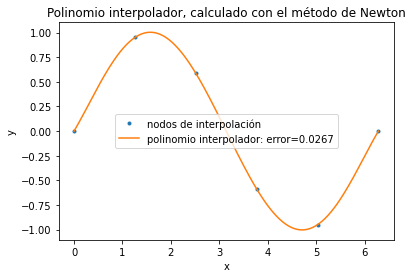

In [18]:
xs = np.linspace(0,2*np.pi,6)
ys = np.sin(xs)
M = difdiv(xs, ys)
cs_Newton = M[0,:]
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,2*np.pi,200)
y_eval = eval_poli_Newton(xs, cs_Newton, x_eval)

# ys_true es la función que queremos interpolar evaluada en x_eval
ys_true = np.sin(x_eval)

# np.abs(ys-y_eval).max() es el error máximo, de entre los 200 puntos de x_eval
# que es representativo del error cometido.
error = np.abs(ys_true-y_eval).max()

plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador: error=%.4f'%error)
plt.title('Polinomio interpolador, calculado con el método de Newton')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

 - **extra** Evalúa el polinomio usando la evaluación anidada (método de Horner)
$$
P(x)=f[x_{0}] + (x-x_{0})\Big(
f[x_{0},x_{1}]+(x-x_{1})\big(
f[x_{0},x_{1},x_{2}] + 
\cdots +(x-x_{{N-1}})f[x_{0},\ldots ,x_{N}]
\big)\Big)
$$

In [19]:
def eval_poli_Newton_Horner(xs, cs, x_eval):
    d = len(xs) - 1
    y_eval = np.ones_like(x_eval)*cs[-1]

    for i in range(2,d+2):
        y_eval = y_eval*(x_eval-xs[-i]) + cs[-i]
    return y_eval

In [20]:
eval_poli_Newton(xs, cs_Newton, 1.0)

0.8339637541406077

In [21]:
eval_poli_Newton_Horner(xs, cs_Newton, 1.0)

0.8339637541406077

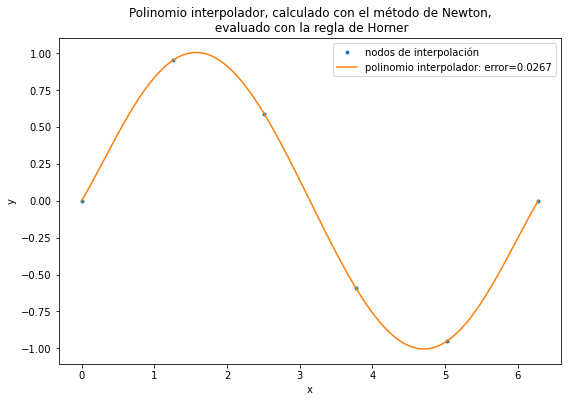

In [22]:
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(0,2*np.pi,200)
y_eval = eval_poli_Newton_Horner(xs, cs_Newton, x_eval)

# ys_true es la función que queremos interpolar evaluada en x_eval
ys_true = np.sin(x_eval)

# np.abs(ys-y_eval).max() es el error máximo, de entre los 200 puntos de x_eval
# que es representativo del error cometido.
error = np.abs(ys_true-y_eval).max()

plt.figure(figsize=(9,6))
plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador: error=%.4f'%error)
plt.title('Polinomio interpolador, calculado con el método de Newton,\n evaluado con la regla de Horner')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

 - ¿Cómo añadirías más datos de interpolación sin necesidad de volver a calcular todo el polinomio?
 
> Si queremos añadir otro punto de interpolación, tenemos que añadir otro término $f[x_{0},\ldots ,x_{N+1}](x-x_{0})(x-x_{1})\dots (x-x_{{N}})$. Para ello, sólo necesitamos calcular una diferencia dividida: $f[x_{0},\ldots ,x_{N+1}]$, pero esa diferencia dividida depende de todas las anteriores. Tenemos que añadir otra fila y columna a la matriz de diferencias divididas, y aplicar la fórmula recursiva empezando por la diagonal principal y hacia arriba para rellenar la nueva columna.

In [23]:
def aumentar_matriz_difdiv(Aold, xnew, ynew):
    # nfilas y ncolumnas deberían ser iguales
    n, ncolumnas = Aold.shape
    Anew = np.zeros((n+1, n+1))
    Anew[:n,:n] = Aold
    # y rellenamos la última columna (la última fila se queda con ceros)
    # primero el elemento de la diagonal
    Anew[n,n] = ynew
    # y después de la diagonal principal hacia arriba
    for i in range(1,n+1):
        # fila i, última columna: usamos la definición recursiva
        Anew[n-i,-1] = (Anew[n-i,-2] - Anew[n-i+1,-1])/(xs[n-i]-xnew)
    return Anew

> Para comparar el resultado, hacemos dos cosas:
> 1. Construimos la matriz de diferencias divididas que corresponde a las listas xs = [x0,x1,...,xn] e ys = [y0,y1,...,yn], y luego la aumentamos con (xnew, ynew) usando `aumentar_matriz_difdiv`.
> 1. Aumentamos las listas xs e ys con xnew e ynew: `xs_full = [x0,x1,...,xn,xnew]`, `ys_full = [y0,y1,...,yn,ynew]`, y llamamos directamente a `difdiv`. El resultado debería ser igual.

In [24]:
xs = np.array([1,2,3,4])
ys = xs**3 - xs
A = difdiv(xs, ys)
print(A)
xnew, ynew = 5, 1
A_aumentada = aumentar_matriz_difdiv(A, xnew, ynew)
print(A_aumentada)

[[ 0.  6.  6.  1.]
 [ 0.  6. 18.  9.]
 [ 0.  0. 24. 36.]
 [ 0.  0.  0. 60.]]
[[  0.           6.           6.           1.          -4.95833333]
 [  0.           6.          18.           9.         -18.83333333]
 [  0.           0.          24.          36.         -47.5       ]
 [  0.           0.           0.          60.         -59.        ]
 [  0.           0.           0.           0.           1.        ]]


In [25]:
xs_full = np.hstack((xs, [xnew]))
ys_full = np.hstack((ys, [ynew]))
A_full = difdiv(xs_full, ys_full)
print(A_full)

[[  0.           6.           6.           1.          -4.95833333]
 [  0.           6.          18.           9.         -18.83333333]
 [  0.           0.          24.          36.         -47.5       ]
 [  0.           0.           0.          60.         -59.        ]
 [  0.           0.           0.           0.           1.        ]]


#### Curiosidad: sympy (opcional)

> Podemos mostrar los polinomios con sympy, y obtener sus coeficientes en la base habitual 
```
p(x) = a0 + a1*x + ... +an*x**n
```

In [26]:
x = sym.symbols('x')

In [27]:
xs = np.arange(-2,2)
ys = np.exp(xs)
xs, ys

(array([-2, -1,  0,  1]),
 array([0.13533528, 0.36787944, 1.        , 2.71828183]))

In [28]:
V = vandermonde(xs)
cs = la.solve(V, ys)
cs

array([1.        , 1.06077038, 0.54308063, 0.11443081])

In [29]:
np.polyfit(xs, ys, len(xs)-1)

array([0.11443081, 0.54308063, 1.06077038, 1.        ])

In [30]:
lagrange(xs, ys, x).expand()

0.114430811456127*x**3 + 0.543080634815244*x**2 + 1.06077038218767*x + 1.0

In [31]:
M = difdiv(xs, ys)
cs = M[0,:]
# un poco raro, poli es un array 0-dimensional. Es consecuencia de usar zeros_like
# abajo veremos otra alternativa
poliN = eval_poli_Newton(xs, cs, x)
print(poliN)
print(poliN.expand())

0.114430811456127*x*(x + 1)*(1.0*x + 2.0) + 0.23254415793483*x + 0.199788200446864*(x + 1)*(1.0*x + 2.0) + 0.600423599106272
0.114430811456127*x**3 + 0.543080634815244*x**2 + 1.06077038218767*x + 1.0


In [32]:
poliH = eval_poli_Newton_Horner(xs, cs, x)
print(poliH)
print(poliH.expand())

(x + 2)*((0.114430811456127*x + 0.199788200446864)*(x + 1) + 0.23254415793483) + 0.135335283236613
0.114430811456127*x**3 + 0.543080634815244*x**2 + 1.06077038218767*x + 1.0


## Análisis del error del polinomio interpolador


El error que cometemos cuando reemplazamos una función $f(x)$ por el polinomio de interpolación $P(x)$ por puntos $x_0,x_1,\ldots,x_N$ **distintos** es:

$$
f(x)-P(x)=\frac{(x-x_0)(x-x_1)\dots (x-x_N)}{(N+1)!}f^{(N+1)}(\xi_x),
$$

donde el punto $\xi_x$ cumple que

$$
\min(a,x)\leq \xi_x \leq \max(b,x)
$$

siendo 

$$
a:=\min (x_0,\dots,x_N),\quad b:=\max(x_0,\dots,x_N).
$$

Detalle matemático: la fórmula para el error sólo se puede aplicar cuando $f$ posee $N$ derivadas continuas en el intervalo $[a,b]$ y la derivada $f^{(N+1)}$ existe en $(a,b)$.

### Algunos casos particulares

Veamos en detalle el caso del  polinomio interpolador $P_1(x)$ de $f(x)$ por dos puntos $x_0<x_1$. Esto se conoce como **interpolación lineal**.

En ese caso, si $x_0<x<x_1$,

$$
f(x)-P_1(x)=\frac{(x-x_0)(x-x_1)}{2}f''(\xi_x),\quad \text{para algún }\xi_x\text{ entre }x_0, x_1.
$$

Obsérvese que la expresión $|(x-x_0)(x-x_1)|$ alcanza su máximo en el punto medio $x_{1/2}:=(x_0+x_1)/2$. Este valor máximo es:

$$
|(x_{1/2}-x_0)(x_{1/2}-x_1)|=\frac{|x_1-x_0|^2}{4}.
$$

Si el módulo de la derivada segunda de $f$ está acotada entre $x_0$ y $x_1$, 

$$
|f''(x)|\leq M_2\quad\text{ para todos los }x\text{ entre }x_0, x_1,
$$

entonces el error se estima por:

$$
|f(x)-P_1(x)|\leq\frac{|x_1-x_0|^2}{8}M_2,\quad \text{ para todos los }x\text{ entre }x_0, x_1.
$$

### Error y diferencias divididas

Es posible demostrar que el polinomio interpolador de $f(x)$ por los puntos $x_0,\dots, x_N$ cumple:

$$
f(x)-P(x)=f[x_{0},\ldots ,x_{N},x](x-x_0)(x-x_1)\dots (x-x_N)
$$

Otro inciso matemático: esta fórmula en cambio, no requiere que existan las derivadas de $f$.

Si combinamos esta última ecuación para el error con la que obtuvimos más arriba concluimos que, siempre que nos den puntos $x_0,\dots, x_{N+1}$ distintos y exista la derivada $f^{(N+1)}$ en intervalo $[a,b]$ cuyos extremos son el mínimo y el máximo de los puntos dados, existe un punto intermedio $\xi_x$ en $(a,b)$ para el que se tiene

$$
f[x_{0},\ldots ,x_{N+1}] = \frac{f^{(N+1}(\xi_x)}{(N+1)!}.
$$

Esto permite dar una interpretación de las diferencias divididas como derivadas.

### Ejercicio

Observa qué ocurre cuando dibujamos las diferencias divididas de orden $k$, para la función $f(x)=\sin(x)$: ¿qué forma tienen esas funciones?

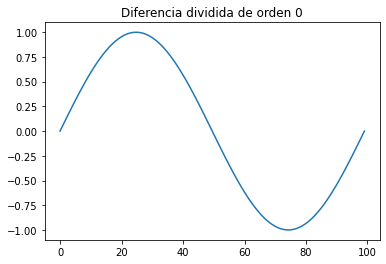

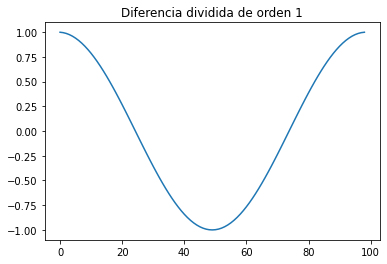

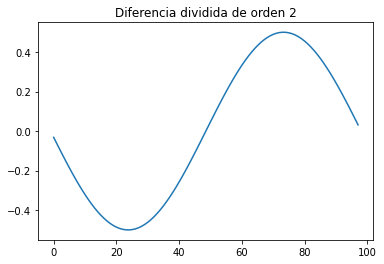

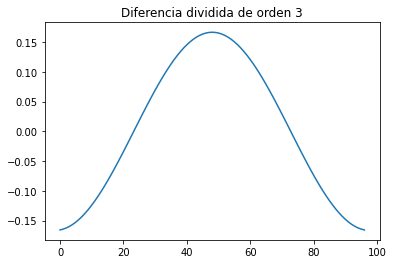

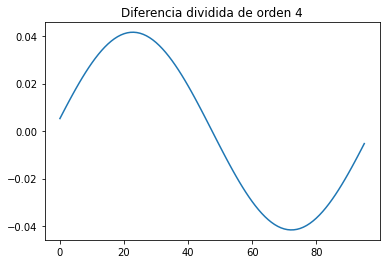

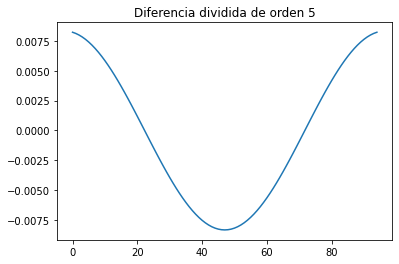

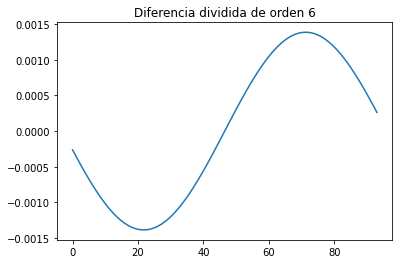

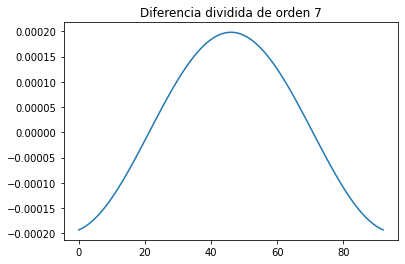

In [33]:
def f(x):
    return np.sin(x)

npoints = 100
xs = np.linspace(0, 2*np.pi, npoints)
ys = f(xs)
M = difdiv(xs, ys)
orden = 8
for k in range(orden):
    plt.figure()
    # Las diagonal k-veces por encima de la principal contiene las diferencias divididas de orden k
    plt.plot(M.diagonal(k))
    plt.title('Diferencia dividida de orden %d'%k)

> - Son senos y cosenos, en el ciclo habitual de la derivada: sin, cos, -sin, -cos

## Convergencia del polinomio interpolador y fenómeno de Runge

Es natural preguntarse, dada una función $f(x)$ definida para $x$ variando en un intervalo $[a,b]$, si al considerar para cada valor de $N$, $N+1$ puntos distintos en dicho intervalo $x_0^{(N)},\dots,x_N^{(N)}$ y el polinomio $P_N(x)$ que interpola $f(x)$ en dichos puntos, ¿es cierto que
$$
\lim_{N\to\infty} P_N(x)=f(x)\text{ ?}
$$

La respuesta es **no**. Si consideramos $N$ puntos _equiespaciados_ en el intervalo $[-1,1]$ entonces la conocida como función de Runge:

$$
f(x) = \frac{1}{1 + 25x^2}
$$

cumple que está siempre mal aproximada por el polinomio interpolador, sin importar cuan grande sea $N$.

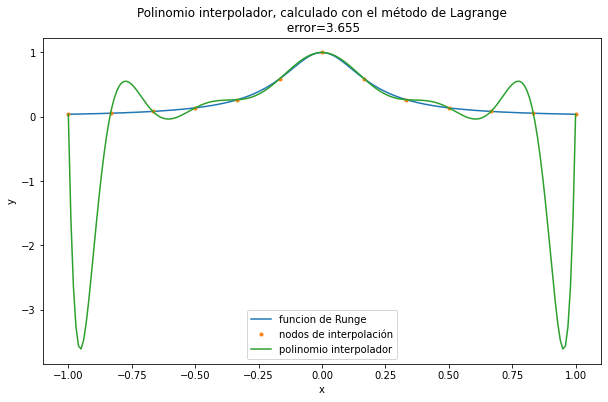

In [34]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
n = 13
xs = np.linspace(-1,1,n)
ys = f(xs)

# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(-1,1,200)
y_eval = lagrange(xs, ys, x_eval)

y_runge = f(x_eval)

plt.figure(figsize=(10,6))
plt.plot(x_eval, y_runge, label='funcion de Runge')
plt.plot(xs, ys, '.', label='nodos de interpolación')
plt.plot(x_eval, y_eval, label='polinomio interpolador')
plt.title('Polinomio interpolador, calculado con el método de Lagrange\n error=%.3f'% 
          np.max(np.abs(y_eval - y_runge)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Ejercicio

- Calcula el máximo error que comete el polinomio interpolador en $N$ puntos equiespaciados del intervalo $[-1,1]$ al aproximar la función de Runge, para todos los valores de $N$ desde 1 hasta 20: ¿cómo se comporta el error?

_(Usa un bucle para almacenar los errores en un array, dibuja el error como función del número de puntos de interpolación)_

> Primero los dibujamos

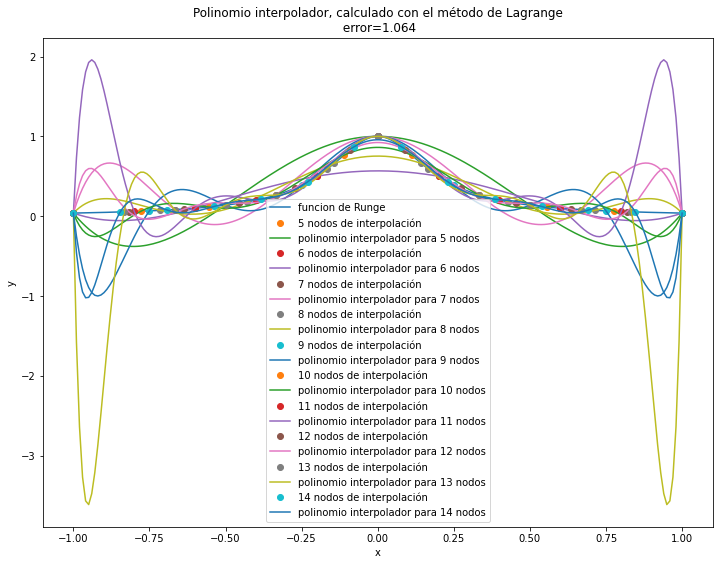

In [35]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)


plt.figure(figsize=(12,9))
x_eval = np.linspace(-1,1,200)
y_runge = f(x_eval)
plt.plot(x_eval, y_runge, label='funcion de Runge')

for n in range(5,15):
    xs = np.linspace(-1,1,n)
    ys = f(xs)

    # Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
    y_eval = lagrange(xs, ys, x_eval)
    plt.plot(xs, ys, 'o', label='%d nodos de interpolación'%n)
    plt.plot(x_eval, y_eval, label='polinomio interpolador para %d nodos'%n)
plt.title('Polinomio interpolador, calculado con el método de Lagrange\n error=%.3f'% 
          np.max(np.abs(y_eval - y_runge)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

> Nos limitamos a guardar el error máximo en un array, como nos pedían.

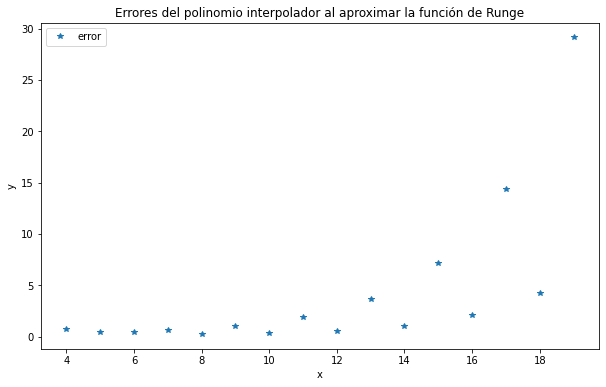

In [36]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
ns = range(4,20)
errores = np.zeros([len(ns)])
for j in range(len(ns)):
    n = ns[j]
    xs = np.linspace(-1,1,n)
    ys = f(xs)
    cs = np.polyfit(xs, ys, n-1)
    # Ahora evaluamos en un array de 200 puntos, para estimar el error del polinomio interpolador
    x_eval = np.linspace(-1,1,200)
    y_eval = lagrange(xs, ys, x_eval)
    y_runge = f(x_eval)
    errores[j] = np.max(np.abs(y_runge-y_eval))

plt.figure(figsize=(10,6))
plt.plot(ns, errores, '*', label='error')
plt.title('Errores del polinomio interpolador al aproximar la función de Runge')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

> Al principio el error disminuye, después crece. Es mayor para un número impar de puntos.
> Si nos quedamos con unos cuantos valores de n comenzando por ejemplo en 8, y hacemos una gráfica logarítmica, los errores con número par de nodos parecen seguir un patrón lineal, y los errores con número impar de nodos otro patrón distinto, lo que indicaría que el error crece de forma exponencial.

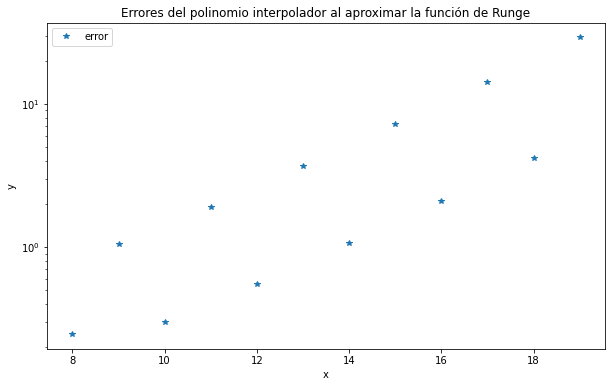

In [37]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
ns = range(8,20)
errores = np.zeros([len(ns)])
for j in range(len(ns)):
    n = ns[j]
    xs = np.linspace(-1,1,n)
    ys = f(xs)
    cs = np.polyfit(xs, ys, n-1)
    # Ahora evaluamos en un array de 200 puntos, para estimar el error del polinomio interpolador
    x_eval = np.linspace(-1,1,200)
    y_eval = lagrange(xs, ys, x_eval)
    y_runge = f(x_eval)
    errores[j] = np.max(np.abs(y_runge-y_eval))

plt.figure(figsize=(10,6))
plt.semilogy(ns, errores, '*', label='error')
plt.title('Errores del polinomio interpolador al aproximar la función de Runge')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## Bonus: como evitar el fenómeno de Runge. Nodos de Chebyshev

Sin embargo, es posible usar para interpolar coordenadas $x_i$ que no están equiespaciadas y que interpolan mucho mejor, tanto en teoría como en la práctica.

No entraremos en detalles, pero estos puntos (llamados __nodos de Chebyshev__) dan mucho mejor resultado que los nodos equiespaciados. Para el intervalo $[-1,1]$, esos nodos son:

$$
    x_k = \cos\left( \frac{(2k - 1) \pi}{2 N} \right ) \quad \text{for} \quad k=1, \ldots, N
$$

Observa que hay más nodos cerca de los extremos del intervalo que en el interior. 


Concretamente, los nodos de Chebyshev son los que hacen que la expresión que aparece en la fórmula del error vale:

$$
\max_{x\in [-1,1]} |(x-x_0)(x-x_1)\dots(x-x_N)|=\frac{1}{2^N}
$$

y se puede demostrar que este valor es el más pequeño posible de entre todas las posibles elecciones de nodos en el intervalo $[-1,1]$. 

En caso de tener que trabajar en otro intervalo $[a,b]$ los nodos de Chebyshev se tienen que rescalar:

$$
X_k=\frac{1}{2}[(b-a)x_k+(a+b)],
$$

siendo $x_k$ los nodo de Chebyshev para $[-1,1]$. En general, estos nuevos nodos **no minimizan** el coeficiente que acompaña la derivada $(N+1)$ de $f$ en la formula del error; se puede comprobar que cumplen:

$$
\max_{x\in [-1,1]} |(x-X_0)(x-X_1)\dots(x-X_N)|=\frac{1}{2^N}\left(\frac{b-a}{2}\right)^{N+1}.
$$

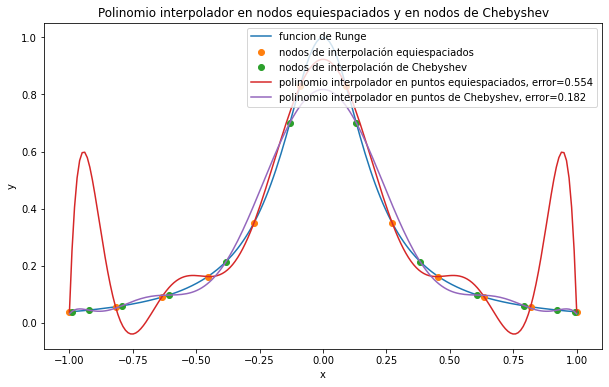

In [38]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
n = 12
xs_equi = np.linspace(-1,1,n)
ys_equi = f(xs_equi)

xs_cheb = np.array([np.cos(((2*k-1)*np.pi)/(2*n)) for k in range(1,n+1)])
ys_cheb = f(xs_cheb)

# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(-1,1,200)
y_lagrange_equi = lagrange(xs_equi, ys_equi, x_eval)
y_lagrange_cheb = lagrange(xs_cheb, ys_cheb, x_eval)
y_runge = f(x_eval)

plt.figure(figsize=(10,6))
plt.plot(x_eval, y_runge, label='funcion de Runge')
plt.plot(xs_equi, ys_equi, 'o', label='nodos de interpolación equiespaciados')
plt.plot(xs_cheb, ys_cheb, 'o', label='nodos de interpolación de Chebyshev')
plt.plot(x_eval, y_lagrange_equi, 
         label='polinomio interpolador en puntos equiespaciados, error=%.3f'%
                np.max(np.abs(y_lagrange_equi - y_runge)))
plt.plot(x_eval, y_lagrange_cheb, 
         label='polinomio interpolador en puntos de Chebyshev, error=%.3f'%
                np.max(np.abs(y_lagrange_cheb - y_runge)))
plt.title('Polinomio interpolador en nodos equiespaciados y en nodos de Chebyshev' )
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

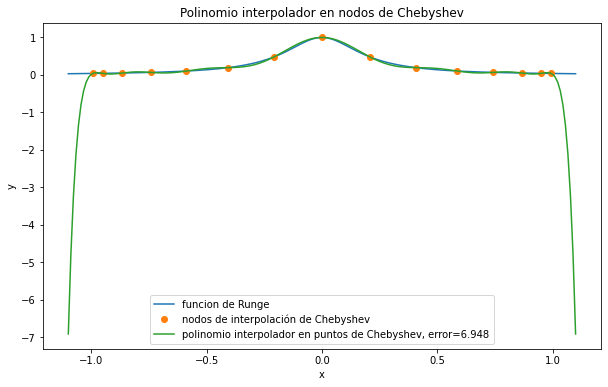

In [39]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
n = 15
xs_equi = np.linspace(-1,1,n)
ys_equi = f(xs_equi)

xs_cheb = np.array([np.cos(((2*k-1)*np.pi)/(2*n)) for k in range(1,n+1)])
ys_cheb = f(xs_cheb)

# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(-1.1,1.1,200)
y_lagrange_equi = lagrange(xs_equi, ys_equi, x_eval)
y_lagrange_cheb = lagrange(xs_cheb, ys_cheb, x_eval)
y_runge = f(x_eval)

plt.figure(figsize=(10,6))
plt.plot(x_eval, y_runge, label='funcion de Runge')
plt.plot(xs_cheb, ys_cheb, 'o', label='nodos de interpolación de Chebyshev')
plt.plot(x_eval, y_lagrange_cheb, 
         label='polinomio interpolador en puntos de Chebyshev, error=%.3f'%
                np.max(np.abs(y_lagrange_cheb - y_runge)))
plt.title('Polinomio interpolador en nodos de Chebyshev' )
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Ejercicio

- Dibuja todos los polinomios de la base de Lagrange para 10 nodos de Chebyshev en el intervalo $[-1,1]$.
- Calcula el máximo error que comete el polinomio interpolador en $N$ nodos de Chebyshev del intervalo $[-1,1]$ al aproximar la función de Runge, para todos los valores de $N$ desde 1 hasta 20: ¿cómo se comporta el error?

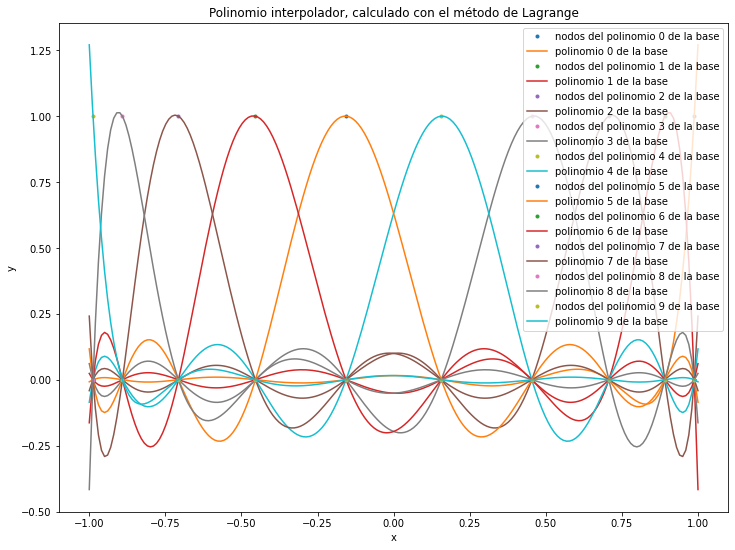

In [40]:
# Mismo código que cuando lo hicimos antes, salvo que xs no son nodos equiespaciados:
# xs = np.arange(1,11)
n = 10
xs_cheb = np.array([np.cos(((2*k-1)*np.pi)/(2*n)) for k in range(1,n+1)])
# Ahora evaluamos en un array de puntos, para dibujar el polinomio interpolador
x_eval = np.linspace(-1,1,200)
plt.figure(figsize=(12,9))
for n in range(10):
    ys = np.zeros(10)
    ys[n] = 1
    y_eval = lagrange(xs_cheb, ys, x_eval)
    plt.plot(xs_cheb, ys, '.', label='nodos del polinomio %d de la base'%n)
    plt.plot(x_eval, y_eval, label='polinomio %d de la base'%n)
plt.title('Polinomio interpolador, calculado con el método de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

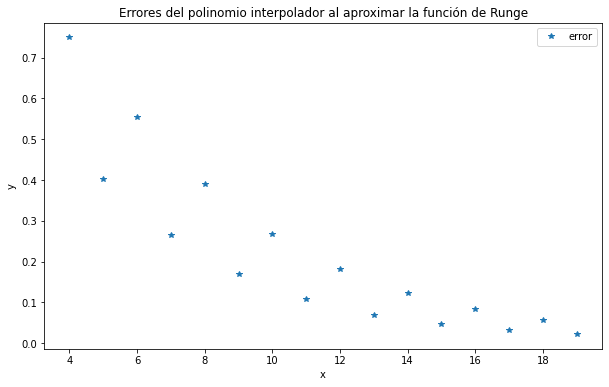

In [41]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
ns = range(4,20)
errores = np.zeros([len(ns)])
for j in range(len(ns)):
    n = ns[j]
    # Mismo código que cuando lo hicimos antes, pero con nodos de Chebychev
    # xs = np.linspace(-1,1,n)
    xs_cheb = np.array([np.cos(((2*k-1)*np.pi)/(2*n)) for k in range(1,n+1)])
    ys = f(xs_cheb)
    cs = np.polyfit(xs_cheb, ys, n-1)
    # Ahora evaluamos en un array de 200 puntos, para estimar el error del polinomio interpolador
    x_eval = np.linspace(-1,1,200)
    y_eval = lagrange(xs_cheb, ys, x_eval)
    y_runge = f(x_eval)
    errores[j] = np.max(np.abs(y_runge-y_eval))

plt.figure(figsize=(10,6))
plt.plot(ns, errores, '*', label='error')
plt.title('Errores del polinomio interpolador al aproximar la función de Runge')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

> El error disminuye, de forma exponencial, como comprobamos al dibujar el número de nodos n contra el logaritmo del error

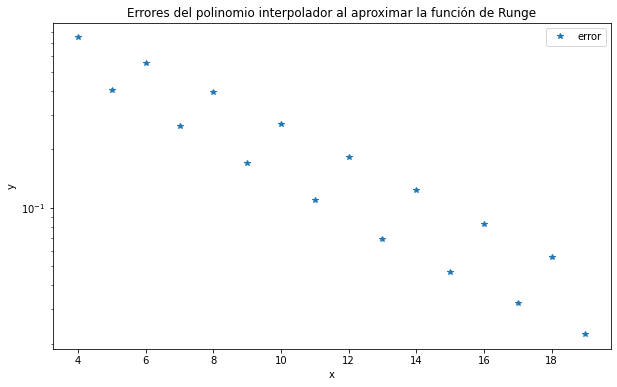

In [42]:
## Comparamos la función de Runge con el polinomio interpolador
# en unos cuantos puntos equiespaciados

def f(x):
    return 1/(1+25*x**2)

# Nodos de interpolación
ns = range(4,20)
errores = np.zeros([len(ns)])
for j in range(len(ns)):
    n = ns[j]
    # Mismo código que cuando lo hicimos antes, pero con nodos de Chebychev
    # xs = np.linspace(-1,1,n)
    xs_cheb = np.array([np.cos(((2*k-1)*np.pi)/(2*n)) for k in range(1,n+1)])
    ys = f(xs_cheb)
    cs = np.polyfit(xs_cheb, ys, n-1)
    # Ahora evaluamos en un array de 200 puntos, para estimar el error del polinomio interpolador
    x_eval = np.linspace(-1,1,200)
    y_eval = lagrange(xs_cheb, ys, x_eval)
    y_runge = f(x_eval)
    errores[j] = np.max(np.abs(y_runge-y_eval))

plt.figure(figsize=(10,6))
plt.semilogy(ns, errores, '*', label='error')
plt.title('Errores del polinomio interpolador al aproximar la función de Runge')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## Interpolación de Hermite

Una generalización del polimonio de interpolación es la siguiente. Dados $(N+1)$ puntos $x_0,\dots,x_N$ distintos, buscamos un polinomio $P(x)$ que ajuste los datos:

$$
P(x_0)=y_0,\dots, P(x_N)=y_N
$$

así como los de las derivadas

$$
P'(x_0)=z_0,\dots, P'(x_N)=z_N.
$$

Estas son $2N+2$ condiciones, por lo que es natural buscar $P(x)$ como un polinomio de grado menor o igual a $2N+1$.

Para calcular $P(x)$ se puede utilizar el método de fuerza bruta (añadiendo las ecuaciones pra las derivadas); se puede probar que dicho polinomio existe y es único. Se suele llamar **polinomio de Hermite** o **polinomio osculador**. 

También existe un análogo de la forma de Lagrange.

Ésta se conoce como **forma de Hermite**, y consiste en obtener el poliniomio $P(x)$ como:

$$
P(x)=\sum_{i=0}^N y_i H_{i}(x) + \sum_{i=0}^N z_i \hat{H}_{i}(x)
$$
donde
- $H_i$ es _"el único polinomio de grado $\leq 2N+1$ tal que"_:
\begin{split}
H_{i}(x_k)=0 & \text{ si } k\neq i \\
H_i'(x_k) = 0 & \text{ para todo }k\\
H_{i}(x_i)=1 &
\end{split}
- $\hat{H}_i$ es _"el único polinomio de grado $\leq 2N+1$ tal que"_:
\begin{split}
\hat{H}_i(x_k) = 0 & \text{ para todo }k \\
\hat{H}_{i}'(x_k)=0 & \text{ si } k\neq i \\
\hat{H}_{i}'(x_i)=1 &
\end{split}

Estos polinomios forman la **base de Hermite** y se pueden expresar en términos de los polinomios de la base de Lagrange:

$$
H_i(x)=[1-2\ell_i'(x_i)(x-x_i)]\ell_i^2(x),
$$

$$
\hat{H}_i(x)=(x-x_i)\ell_i^2(x).
$$
El error cometido cuando interpolamos una función $f(x)$ mediante este procedimiento es, bajo condiciones similares a la fórmula para el polinomio interpolador:

$$
f(x)-P(x)=\frac{[(x-x_0)(x-x_1)\dots (x-x_N)]^2}{(2N+2)!}f^{(2N+2)}(\xi_x).
$$

## Interpolación polinómica a trozos. Splines lineales

Vamos a cambiar ahora la filosofía. En lugar de tratarde interpolar una serie de datos y valores por una serie de puntos mediante un único polinomio, vamos a hacerlo mediante funciones que son **polinomiales a trozos**. Dicho más precisamente, si tomamos puntos

$$
a=x_0<x_1<\dots<x_{N-1}<x_N=b,
$$

buscamos interpolar unos datos/puntos mediante funciones $s(x)$ que sean continuas y que cumplan: para los $x$ dentro de un intervalo $[x_i,x_{i+1}]$ la función $s(x)$ coincide con un polinomio de grado $r$.

El caso más sencillo se da cuando el grado de los polinomios es uno. Este caso se conoce como **interpolación lineal a trozos**. Si queremos interpolar los datos $f(x_0),\dots,f(x_N)$ entonces si $x_i\leq x \leq x_{i+1}$ se cumple:

$$
s_N(x)=f(x_i)+f[x_i,x_{i+1}](x-x_i),
$$

donde, recordamos, 

$$
f[x_i,x_{i+1}]=\frac{f(x_{i+1})-f(x_i)}{x_{i+1}-x_i}.
$$

El error cometido mediante esta aproximación es, si $x_i\leq x \leq x_{i+1}$

$$
|f(x)-s_N(x)|\leq \frac{(x_{i+1}-x_i)^2}{8}\max_{[x_i,x_{i+1}]}|f''(x)|.
$$

De aquí se sigue que para un $x$ cualquiera dentro del intervalor $[a,b]$:

$$
|f(x)-s_N(x)|\leq \frac{h^2}{8}\max_{[a,b]}|f''(x)|.
$$

donde

$$
h=\max_{i=0,\dots,N-1}|x_{i+1}-x_i|.
$$

En particular, cuando la segunda derivada de $f$ existe y está acotada:

$$
f(x)-s_N(x)\to 0,\quad N\to\infty \text{ y } h\to 0.
$$

Este método tiene claras

ventajas:
- El costo de evaluar $s$ no crece con $N$, mientras que en el caso del polinomio interpolador sí lo hace.
- El polinomio interpolador no converge a la función que interpola cuando $N$ tiende a infinito. La interpolación  lineal a trozos sí lo hace

y un claro inconveniente:
- El polinomio interpolador es infinitamente derivable; los interpoladores $s_N$ no son siquiera derivables en los nodos de interpolación.

### Combinaciones lineales de funciones

Vamos a ver que la interpolación lineal se puede escribir en la forma:

$$
s_N(x)=y_0L_0(x)+y_1L_1(x)+\dots+y_NL_N(x),
$$

como sucedía con las formas de Lagrange o Hermite para el polinomio interpolador. 

Las funciones $L_j(x)$ se llaman **elementos finitos de orden 1** o **splines lineales**:

![](finite_element_d1.png)

![](finite_element_d1_bis.png)

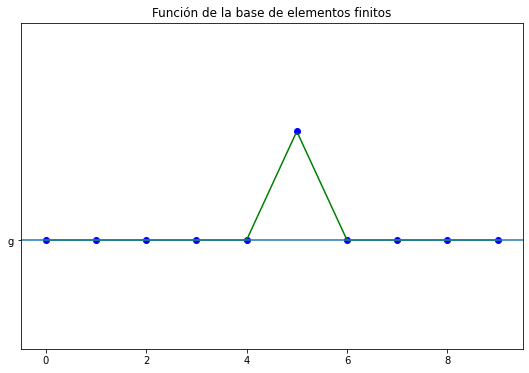

In [43]:
from scipy.interpolate import UnivariateSpline
k=1 #EJERCICIO: CAMBIA EL VALOR DE k
x = np.arange(10)
y = [0]*(len(x)); y[5]=1
cs3 = UnivariateSpline(x, y, k=k, s=0)
xs = np.linspace(min(x), max(x), 200)
plt.figure(figsize=(9, 6))
plt.plot(x, y[:len(x)], 'bo', label='data')
plt.plot(xs, cs3(xs), 'g-', label="L3")
plt.axhline('g')
plt.title('Función de la base de elementos finitos')
plt.xlim(-0.5, 9.5);plt.ylim(-1,2);

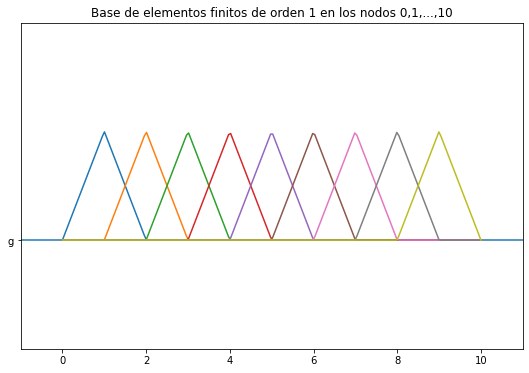

In [44]:
from scipy.interpolate import UnivariateSpline
k=1 #EJERCICIO: CAMBIA EL VALOR DE k
N = 10
b
plt.figure(figsize=(9, 6))
plt.axhline('g')
plt.title('Base de elementos finitos de orden 1 en los nodos 0,1,...,%d'%N)
for i_one in range(1,N):
    y = [0]*(len(x)); y[i_one]=1
    cs3 = UnivariateSpline(x, y, k=k, s=0)
    plt.plot(xs, cs3(xs), '-', label="L3")
plt.xlim(-1, N+1);plt.ylim(-1,2);

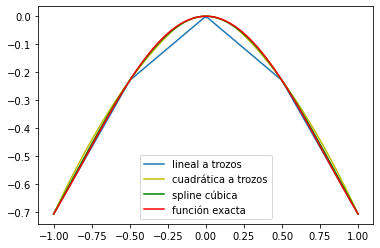

In [21]:
from scipy.interpolate import UnivariateSpline, CubicSpline

k=1 #EJERCICIO: CAMBIA EL VALOR DE k
x = np.linspace(-1,1,5)
y = np.cos(x)**2-1
xs =  np.linspace(-1,1,100)
ys = np.cos(xs)**2-1
cs3 = CubicSpline(x, y)

cs1 = UnivariateSpline(x, y, k=k, s=0)
cs2 = UnivariateSpline(x, y, k=2, s=0)
plt.plot(xs, cs1(xs), '-', label="lineal a trozos")
plt.plot(xs, cs2(xs), 'y-', label="cuadrática a trozos")
plt.plot(xs, cs3(xs), 'g-', label="spline cúbica")
plt.plot(xs, ys,'r', label="función exacta")
plt.legend()
plt.show()

### Ejercicio

Modifica el código más abajo para interpolar las funciones que hemos visto en otros ejemplos mediante interpolación lineal a trozos.

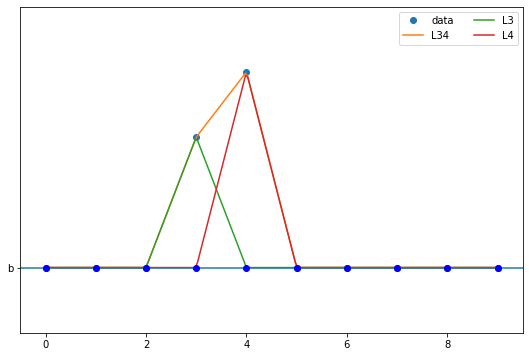

In [45]:
from scipy.interpolate import UnivariateSpline
k = 1
x = np.arange(10)
y = [0]*10; y[3]=2; cs3 = UnivariateSpline(x, y, k=k, s=0)
y = [0]*10; y[4]=3; cs4 = UnivariateSpline(x, y, k=k, s=0)
y = [0]*10; y[3]=2; y[4]=3; cs34 = UnivariateSpline(x, y, k=k, s=0)
xs = xs = np.linspace(min(x), max(x), 200)
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'o', label='data')
plt.plot(xs, cs3(xs) + cs4(xs), label="L34")
plt.plot(xs, cs3(xs), label="L3")
plt.plot(xs, cs4(xs), label="L4")
plt.legend(ncol=2)
plt.axhline('b')
plt.plot(x, [0]*len(x), 'bo')
plt.xlim(-0.5, 9.5); plt.ylim(-1,4);

## Interpolación polinómica a trozos. Splines cúbicas

Si en lugar de funciones lineales utilizamos polinomios de grado tres, obtenemos la interpolación por **splines cúbicas**. 


Una función __spline__ es una función que interpola varios puntos $(x_j, y_j)$: es un polinomio cúbico $S_j$ en cada intervalo $[x_{j},x_{j+1}]$ que interpola los valores dados:

 - $S_j(x_j) = y_j,\; S_j(x_{j+1}) = y_{j+1}$

y además:

 - $S_{j+1}'(x_{j+1})=S_j'(x_{j+1})$, $\quad j=0,1,\ldots,N-2$ ($S'$ es continua en los nodos)
 - $S_{j+1}''(x_{j+1})=S_j''(x_{j+1})$, $\quad j=0,1,\ldots,N-2$ ($S''$ es continua en los nodos)

Estas condiciones plantean un sistema de $4N-2$ ecuaciones y $4N$ incógnitas, de modo que es habitual completarlo con una condición extra en cada extremo: una en $x_0$ y otra en $x_N$ (aunque también es habitual imponer una condición extra en $x_1$ y otra en $x_{N-1}$).


Para interpolar mediante un spline cúbico sobre un conjunto $x_0,\dots,x_N$, de modo que $f(x_i)=y_i$ podemos proceder como conl a aproximación lineal a trozos:
$$
S(x)=\sum_{i=0}^N y_i B_{i}(x)
$$
donde $B_i$ es _"la única spline cúbica natural en los puntos $x_0,\dots,x_N$ tal que"_:
\begin{split}
B_{i}(x_k)=0 & \text{ si } k\neq i \\
B_{i}(x_i)=1
\end{split}


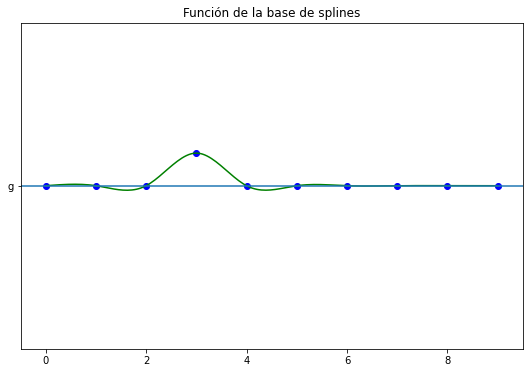

In [46]:
from scipy.interpolate import CubicSpline

x = np.arange(10)
y = [0]*10; y[3]=1
cs3 = CubicSpline(x, y, bc_type='natural')
xs = np.linspace(min(x), max(x), 200)
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'bo', label='data')
plt.plot(xs, cs3(xs), 'g-', label="L3")
plt.axhline('g')
plt.title('Función de la base de splines')
plt.xlim(-0.5, 9.5)
plt.ylim(-5,5)
plt.show()

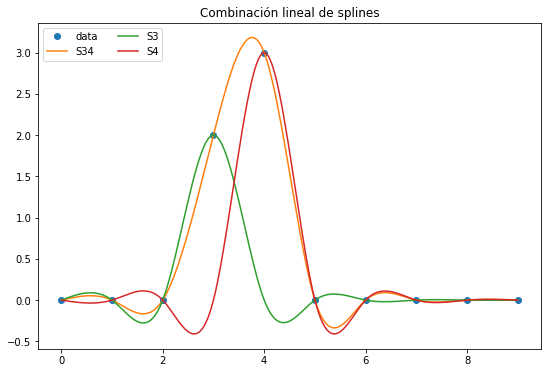

In [56]:
from scipy.interpolate import CubicSpline

x = np.arange(10); y = [0]*10; y[3]=2
cs3 = CubicSpline(x, y, bc_type='natural')
y = [0]*10; y[4]=3
cs4 = CubicSpline(x, y, bc_type='natural')
xs = np.linspace(min(x), max(x), 200)
y = [0]*10; y[3]=2; y[4]=3
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'o', label='data')
plt.plot(xs, cs3(xs) + cs4(xs), label="S34")
plt.plot(xs, cs3(xs), label="S3")
plt.plot(xs, cs4(xs), label="S4")
plt.title('Combinación lineal de splines')
plt.legend(loc='upper left', ncol=2)
plt.show()

### Ejercicio

Lee la documentación de `CubicSpline`:

- Aprende a calcular splines con condiciones de frontera natural y restrigida.
- Aprende a evaluar una función spline en un punto concreto.
- ¿Con qué condiciones de frontera se ha calculado el ejemplo anterior?

In [54]:
help(sp.interpolate.CubicSpline)

Help on class CubicSpline in module scipy.interpolate._cubic:

class CubicSpline(CubicHermiteSpline)
 |  CubicSpline(x, y, axis=0, bc_type='not-a-knot', extrapolate=None)
 |  
 |  Cubic spline data interpolator.
 |  
 |  Interpolate data with a piecewise cubic polynomial which is twice
 |  continuously differentiable [1]_. The result is represented as a `PPoly`
 |  instance with breakpoints matching the given data.
 |  
 |  Parameters
 |  ----------
 |  x : array_like, shape (n,)
 |      1-D array containing values of the independent variable.
 |      Values must be real, finite and in strictly increasing order.
 |  y : array_like
 |      Array containing values of the dependent variable. It can have
 |      arbitrary number of dimensions, but the length along ``axis``
 |      (see below) must match the length of ``x``. Values must be finite.
 |  axis : int, optional
 |      Axis along which `y` is assumed to be varying. Meaning that for
 |      ``x[i]`` the corresponding values are ``

In [70]:
# para evaluar la spline cúbica anterior en un punto concreto x0:
x0=np.pi # prueba con distintos valores
ev = cs3(x0)
print('La spline evaluada en {} da {}'.format(x0,ev))

La spline evaluada en 3.141592653589793 da 1.91849025956987


### Ejercicio

- Interpola la función $f(x)=\sin(x)$ en el intervalo $[0,2\pi]$ usando $N=6$ puntos de interpolación. Estima el máximo error cometido, compáralo con el error que comete el polinomio interpolador.
- Interpola la función de Runge $f(x)=\frac{1}{1+25\cdot x^2}$ en el intervalo $[-1,1]$ usando $N=6$ puntos de interpolación. Estima el máximo error cometido, compáralo con el error que comete el polinomio interpolador.

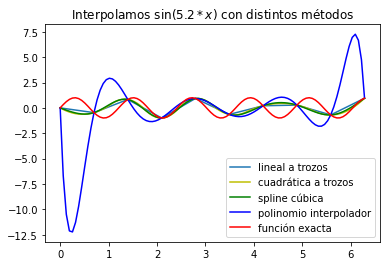

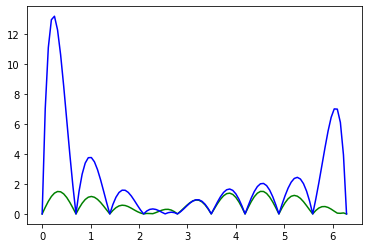

In [52]:
# usamos mejor el sen(5.2x) porque con el seno(x) no se aprecia diferencia entre los distintos métodos.
# metemos más puntos por el mismo motivo
N=10
a=0 
b=2*np.pi

x = np.linspace(0,2*np.pi,N) # prueba dándole distintos valores a N
y = np.sin(5.2*x) # el 5.2 se pone para que la frecuencia no sea múltiplo entero de 2pi

xs =  np.linspace(0,2*np.pi,100)
ys = np.sin(5.2*xs)
cs3 = CubicSpline(x, y, bc_type='natural')
pil = lagrange(x, y, xs)

cs1 = UnivariateSpline(x, y, k=1, s=0)
cs2 = UnivariateSpline(x, y, k=2, s=0)

error_pil = np.abs(ys - pil)
error_cs3 = np.abs(ys - cs3(xs))

plt.plot(xs, cs1(xs), '-', label="lineal a trozos")
plt.plot(xs, cs2(xs), 'y-', label="cuadrática a trozos")
plt.plot(xs, cs3(xs), 'g-', label="spline cúbica")
plt.plot(xs, pil, 'b-', label="polinomio interpolador")
plt.plot(xs, ys,'r', label="función exacta")
plt.title("Interpolamos $\sin(5.2*x)$ con distintos métodos")
plt.legend()
plt.show()

plt.plot(xs, error_cs3, 'g-', label="error spline cúbica")
plt.plot(xs, error_pil, 'b-', label="error polinomio interpolador")
plt.show()

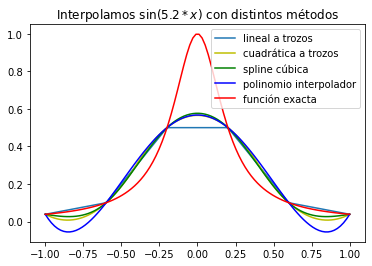

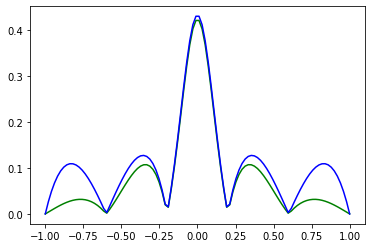

In [51]:
# Repetimos el ejercicio para la función de Runge

N=6
a=-1 
b=1

x = np.linspace(a,b,N) 
y = 1/(1+25*x**2) 
xs =  np.linspace(a,b,100)
ys = 1/(1+25*xs**2)
cs3 = CubicSpline(x, y, bc_type='natural')
pil = lagrange(x, y, xs)

cs1 = UnivariateSpline(x, y, k=1, s=0)
cs2 = UnivariateSpline(x, y, k=2, s=0)

error_pil = np.abs(ys - pil)
error_cs3 = np.abs(ys - cs3(xs))

plt.plot(xs, cs1(xs), '-', label="lineal a trozos")
plt.plot(xs, cs2(xs), 'y-', label="cuadrática a trozos")
plt.plot(xs, cs3(xs), 'g-', label="spline cúbica")
plt.plot(xs, pil, 'b-', label="polinomio interpolador")
plt.plot(xs, ys,'r', label="función exacta")
plt.title("Interpolamos $\sin(5.2*x)$ con distintos métodos")
plt.legend()
plt.show()

plt.plot(xs, error_cs3, 'g-', label="error spline cúbica")
plt.plot(xs, error_pil, 'b-', label="error polinomio interpolador")
plt.show()

### Ejercicio. Compara la base de splines cúbicas con la de Lagrange

La base de splines cúbicas muestra oscilaciones, pero éstas decaen al alejarnos del punto donde la función de la base vale 1.

La base de Lagrange tiene "artefactos", que se exageran en los extremos del intervalo, y por supuesto más allá...

(-5.0, 5.0)

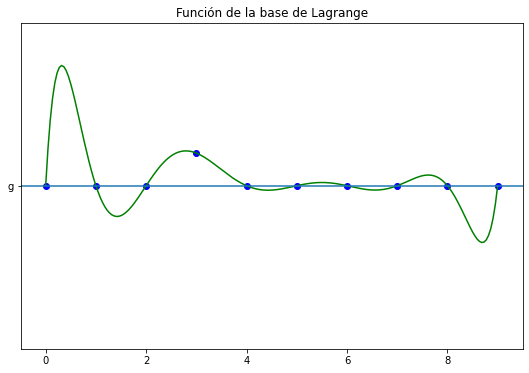

In [48]:
from scipy.interpolate import lagrange

x = np.arange(10)
y = [0]*10; y[3]=1
cs3 = lagrange(x, y)

xs = np.linspace(min(x), max(x), 200)
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'bo', label='data')
plt.plot(xs, cs3(xs), 'g-', label="L3")
plt.axhline('g')
plt.title('Función de la base de Lagrange')
plt.xlim(-0.5, 9.5);plt.ylim(-5,5)

(-5.0, 5.0)

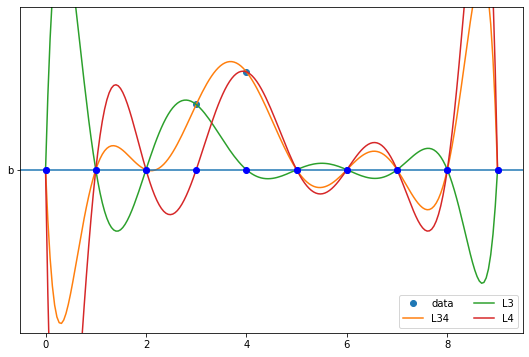

In [49]:
from scipy.interpolate import lagrange
x = np.arange(10)
y = [0]*10; y[3]=2; cs3 = lagrange(x, y)
y = [0]*10; y[4]=3; cs4 = lagrange(x, y)
y = [0]*10; y[3]=2; y[4]=3; cs34 = lagrange(x, y)
xs = np.linspace(min(x), max(x), 200)
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'o', label='data')
plt.plot(xs, cs3(xs) + cs4(xs), label="L34")
plt.plot(xs, cs3(xs), label="L3")
plt.plot(xs, cs4(xs), label="L4")
plt.legend(ncol=2)
plt.axhline('b')
plt.plot(x, [0]*len(x), 'bo')
plt.xlim(-0.5, 9.5); plt.ylim(-5,5)